# Tractament i Anàlisi Exploratori de les Dades

Aquest *notebook* està dedicat al tractament i a l'anàlisi exploratori de les dades dels entrenaments de ciclisme.
En primer lloc, es duran a terme les tasques de preparació de les dades, convertint la versió original (*raw data*) en una versió més simplificada i intuïtiva, que contindrà únicament les variables rellevants per als experiments posteriors.
Un cop fet aquest pas, es faran algunes modificacions addicionals per tal de facilitar-ne la visualització i interpretació.
Finalment, es procedirà a l'anàlisi exploratoria pròpiament dita, mitjançant gràfics i, en alguns casos, proves estadístiques per estudiar les relacions entre variables.


In [4]:
import os  # Interact with the operating system (e.g., file paths)
import glob  # Work with file path patterns (e.g., to list multiple files)
import re  # Regular expressions for string processing
import random  # Generate random numbers (e.g., for sampling)
import pandas as pd  # Data manipulation and analysis
import matplotlib.pyplot as plt  # Plotting and visualization
import numpy as np  # Numerical operations and array handling
from pathlib import Path  # Object-oriented filesystem paths
from datetime import datetime  # Manage date and time objects
import seaborn as sns  # Statistical data visualization
from scipy import stats  # Statistical tests and probability distributions

## Tractament de les Dades

En primer lloc, extraurem la informació rellevant dels fitxers originals.
Els entrenaments són sèries temporals emmagatzemades en fitxers `.csv`, per tant, és fonamental mantenir-ne l’ordre per conservar la coherència temporal.

In [6]:
# Folder containing the raw CSV files (original training data)
input_folder = "raw_csv"

# Folder where the processed CSV files will be saved
output_folder = "files_csv"

# Folder for saving the graphs used in the exploratory analysis
images = "images_exploratory_analysis"

Per tractar les dades farem servir les següents funcions, les col·loquem a una cel·la apart per aconseguir que el codi sigui més intuitiu.

In [8]:
def convert_to_float(df, column_name):
    """Convert a column to float64."""
    df[column_name] = pd.to_numeric(df[column_name], errors='coerce')
    return df[column_name].astype('float64')


def convert_to_int_with_round(series):
    """Round and convert a Series to nullable integer (Int64)."""
    return series.round().astype('Int64')


def generate_readable_name(file_path, counter=1):
    """Generate a readable filename from the original path."""
    
    original_name = Path(file_path).stem
    match = re.match(r'tp-\d+\.(\d{4}-\d{2}-\d{2}).*?\.GarminPing\.(\w+)', original_name)
    
    if match:
        date_str, code = match.groups()
        date = datetime.strptime(date_str, "%Y-%m-%d")
        return f"cycling_{date.strftime('%Y_%m_%d')}_{counter}"
    
    return f"cycling_{datetime.now().strftime('%Y_%m_%d')}_entrenament{counter}"



### Tractament dels Fitxers .CSV

En aquesta secció es realitza el **tractament inicial dels fitxers** d’entrenament en format `.csv`, que contenen sèries temporals enregistrades durant sessions de ciclisme. L’objectiu és extreure’n només la informació rellevant i deixar les dades en un format net, homogeni i preparat per a l’anàlisi i la modelització posterior.

1. **Organització dels fitxers**:
   Es defineixen els directoris d’entrada i sortida, i es crea automàticament la carpeta de destinació si no existeix. També es genera un diccionari per comptabilitzar els entrenaments per data, necessari per a la nomenclatura final dels fitxers tractats.

2. **Lectura i filtratge de les dades**:
   Per a cada fitxer:

   * Es llegeixen les dades i es filtren les files que contenen valors vàlids de *heart rate*.
   * Es renomèn les columnes rellevants amb noms més intuïtius: `timestamp`, `heart_rate`, `cadence`, `distance`, `power`, `temperature`, `speed`, `altitude`.

3. **Conversió de tipus de dades**:

   * Les variables `distance`, `power` i `timestamp` es converteixen a nombres reals (`float64`) mitjançant una funció auxiliar que neteja valors no numèrics si cal.
   * Les variables discretes com `heart_rate` o `cadence` es transformen en enters, tot arrodonint els valors i mantenint possibles valors nuls (tipus `Int64`).

4. **Processament temporal**:

   * El camp `timestamp` es transforma en objectes `datetime` i es configura com a índex temporal.
   * Es calcula la **diferència d’altitud** entre mostres consecutives i se'n calcula una **mitjana mòbil** amb una finestra de 5 mostres (`rolling_ave_alt`) per obtenir una mesura de la variació del terreny.

5. **Neteja final i exportació**:

   * S’omplen els valors nuls generats per càlculs de diferències o mitjanes mòbils.
   * Si el fitxer resultant no conté informació rellevant, s’ignora.
   * En cas contrari, es genera un nom llegible a partir de la data de l'entrenament i es guarda el fitxer net en el directori corresponent.





In [10]:
# Create the output folder if it doesn't exist
Path(output_folder).mkdir(exist_ok=True)

# List all CSV files in the input directory
file_list = glob.glob(os.path.join(input_folder, '*.csv'))

# Dictionary to count how many training sessions occurred per day
sessions_per_day = {}

for file in file_list:
    data = pd.read_csv(file, low_memory=False)

    # Filter rows that contain heart rate data and valid values
    filtered = data[
        (data['Field 12'].astype(str) == "heart_rate") &
        (pd.to_numeric(data['Value 4'], errors='coerce') != 1) &
        (pd.notnull(data['Value 4']))
    ].copy()

    # Rename columns for clarity
    renamed = filtered.rename(columns={
        'Value 1': 'timestamp',
        'Value 12': 'heart_rate',
        'Value 13': 'cadence',
        'Value 4': 'distance',
        'Value 8': 'power',
        'Value 14': 'temperature',
        'Value 7': 'speed',
        'Value 6': 'altitude'
    })[[
        'timestamp', 'heart_rate', 'cadence', 'distance',
        'power', 'temperature', 'speed', 'altitude'
    ]].copy()

    # Convert selected columns to float
    renamed['distance'] = convert_to_float(renamed, 'distance')
    renamed['power'] = convert_to_float(renamed, 'power')
    renamed['timestamp'] = convert_to_float(renamed, 'timestamp')

    # Convert selected columns to integer
    int_cols = ['heart_rate', 'cadence', 'power', 'temperature', 'altitude']
    for col in int_cols:
        renamed[col] = convert_to_int_with_round(renamed[col])
        
    # Convert timestamp to datetime and set as index
    renamed['timestamp'] = pd.to_datetime(renamed['timestamp'], unit='s')
    renamed.set_index('timestamp', inplace=True)

    # Compute difference in altitude
    renamed['alt_difference'] = renamed['altitude'] - renamed['altitude'].shift(1)

    # Compute rolling average of altitude difference (window of 5 samples)
    renamed['rolling_ave_alt'] = renamed['alt_difference'].rolling(window=5).mean()

    # Fill missing values caused by rolling/shifting
    renamed = renamed.bfill()

    # Reset index before saving as standard CSV
    renamed.reset_index(inplace=True)

    # Skip if the resulting DataFrame is empty or contains only NaNs
    if renamed.empty or renamed.dropna().empty:
        print(f"Empty or invalid file skipped: {Path(file).name}")
        continue

    # Generate a readable file name
    date_str = re.search(r'\.(\d{4}-\d{2}-\d{2})', Path(file).stem).group(1)
    sessions_per_day[date_str] = sessions_per_day.get(date_str, 0) + 1
    new_name = generate_readable_name(file, sessions_per_day[date_str])

    # Save the cleaned and processed data
    output_file = os.path.join(output_folder, f"{new_name}.csv")
    renamed.to_csv(output_file, index=False)
    print(f"File saved as: {output_file}")


File saved as: files_csv\cycling_2024_08_06_1.csv
File saved as: files_csv\cycling_2024_08_08_1.csv
File saved as: files_csv\cycling_2024_08_09_1.csv
File saved as: files_csv\cycling_2024_08_10_1.csv
File saved as: files_csv\cycling_2024_08_13_1.csv
File saved as: files_csv\cycling_2024_08_18_1.csv
File saved as: files_csv\cycling_2024_08_20_1.csv
File saved as: files_csv\cycling_2024_08_21_1.csv
File saved as: files_csv\cycling_2024_08_22_1.csv
File saved as: files_csv\cycling_2024_08_26_1.csv
File saved as: files_csv\cycling_2024_08_28_1.csv
File saved as: files_csv\cycling_2024_08_29_1.csv
File saved as: files_csv\cycling_2024_08_30_1.csv
File saved as: files_csv\cycling_2024_08_31_1.csv
File saved as: files_csv\cycling_2024_09_02_1.csv
File saved as: files_csv\cycling_2024_09_03_1.csv
File saved as: files_csv\cycling_2024_09_05_1.csv
File saved as: files_csv\cycling_2024_09_06_1.csv
File saved as: files_csv\cycling_2024_09_08_1.csv
File saved as: files_csv\cycling_2024_09_10_1.csv


### Anàlisi Exploratori Ràpid

Ara farem un petit anàlisi per comprovar com em extret les dades i si es necessari fer alguna modificació extra.
L'anàlisi serà senzill, simplement i imprimirem algunes gràfiques de les variables que volem

Analyzing file: cycling_2024_08_20_1.csv

File loaded successfully

Basic information:
- Number of timesteps: 6182
- Number of variables: 10
- Time range: 2004-08-21 06:57:34 to 2004-08-21 08:44:27

Descriptive statistics:
       heart_rate  cadence  distance    power  temperature    speed  altitude  \
count     6182.00  6182.00   6182.00  6182.00      6182.00  6182.00   6182.00   
mean       151.71    82.23  26591.03   218.68        25.86     8.73    101.60   
std         13.84    13.13  16077.18    93.42         2.29     1.78     25.89   
min         79.00     0.00     17.95     0.00        -3.00     0.00     40.00   
25%        142.00    81.00  12140.43   176.00        25.00     7.61     93.00   
50%        154.00    85.00  27034.56   214.00        26.00     8.51    107.00   
75%        161.00    88.00  40313.51   249.00        27.00     9.74    123.00   
max        182.00   110.00  54318.96   775.00       152.00    14.41    141.00   

       alt_difference  rolling_ave_alt  
count 

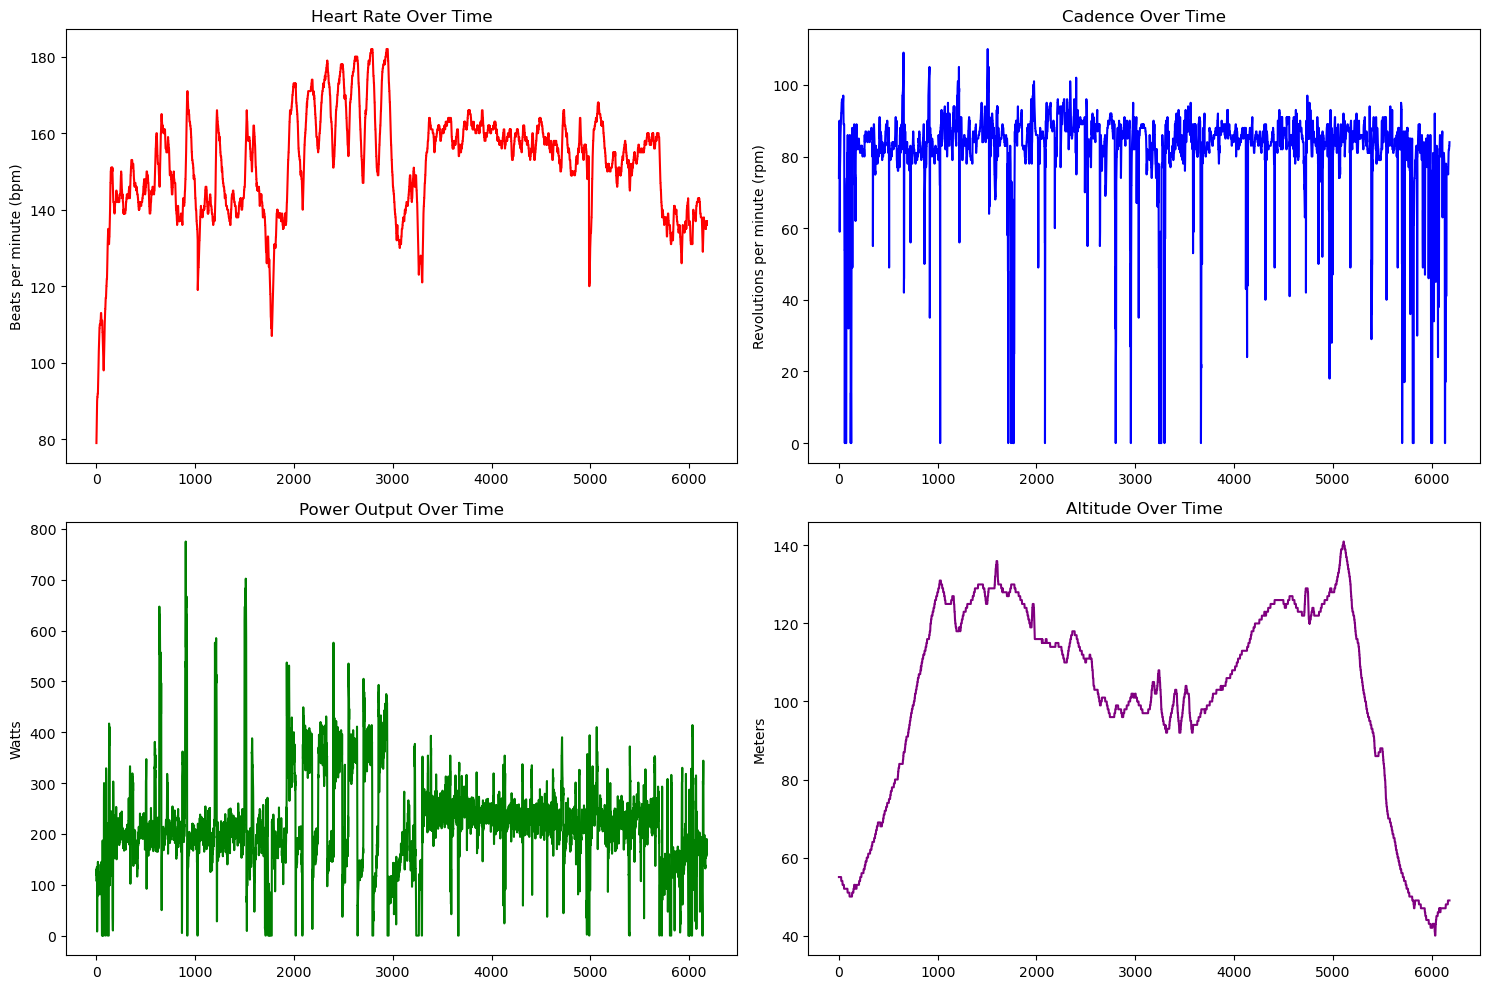


 Data quality check:
- Missing values per variable:
timestamp          0
heart_rate         0
cadence            0
distance           0
power              0
temperature        0
speed              0
altitude           0
alt_difference     0
rolling_ave_alt    0
dtype: int64


In [12]:
# 1. Select a random file from the cleaned dataset directory
files = [f for f in os.listdir(output_folder) if f.endswith('.csv')]
selected_file = random.choice(files)
full_path = os.path.join(output_folder, selected_file)

print(f"Analyzing file: {selected_file}\n")

# 2. Load the selected file
df = pd.read_csv(full_path)
print("File loaded successfully\n")

# 3. Basic info about the dataset
print("Basic information:")
print(f"- Number of timesteps: {len(df)}")
print(f"- Number of variables: {len(df.columns)}")
print(f"- Time range: {df['timestamp'].min()} to {df['timestamp'].max()}\n")

# 4. Descriptive statistics of the dataset
print("Descriptive statistics:")
print(df.describe().round(2))

# 5. Visualizations of key time series
plt.figure(figsize=(15, 10))

# Heart rate plot
plt.subplot(2, 2, 1)
plt.plot(df['heart_rate'], color='red')
plt.title('Heart Rate Over Time')
plt.ylabel('Beats per minute (bpm)')

# Cadence plot
plt.subplot(2, 2, 2)
plt.plot(df['cadence'], color='blue')
plt.title('Cadence Over Time')
plt.ylabel('Revolutions per minute (rpm)')

# Power plot
plt.subplot(2, 2, 3)
plt.plot(df['power'], color='green')
plt.title('Power Output Over Time')
plt.ylabel('Watts')

# Altitude plot
plt.subplot(2, 2, 4)
plt.plot(df['altitude'], color='purple')
plt.title('Altitude Over Time')
plt.ylabel('Meters')

plt.tight_layout()
plt.show()

# 6. Check for missing values
print("\n Data quality check:")
print("- Missing values per variable:")
print(df.isnull().sum())


### Correccions

Com podem veure, l'anàlisi és prou bo, encarra que podem millorar una mica el fitxer.
- Notem que el `timestamp` té uns valors molt extranys, realment les mostres estan preses cada segon, per tant, podem canviar aquesta variable per un espècie d'índex, on cada fila sigui un segon de la nostra mostra.
- Les gràfiques de cadència i potència presenten molta variància, aquesta és deguda a com es va en bici, per tant una idea per reduir-la i que la gràfica sigui més bona de llegir, és fer una finestra de 10 observacions i calcular la mitjana, així és suavitzarà la gràfica.

In [14]:
# Configuration
input_folder = "files_csv"
file_list = [f for f in os.listdir(input_folder) if f.endswith('.csv')]

def process_file(path):
    df = pd.read_csv(path)

    for col in ['power', 'cadence']:
        df[col] = pd.to_numeric(df[col], errors='coerce').astype('float64')
    
    df['timestamp'] = range(1, len(df) + 1)

    for col in ['power', 'cadence']:
        df[col] = df[col].replace(0, pd.NA)
        df = df.infer_objects(copy=False) 
        df[col] = df[col].interpolate().ffill().bfill().astype('float64')
        df[f'{col}_ma'] = df[col].rolling(window=30, min_periods=1).mean()

    df.to_csv(path, index=False)
    return True

# Process all files
success_count = 0

for file in file_list:
    path = os.path.join(input_folder, file)
    process_file(path)
    print(f"{file} processed successfully")
    success_count += 1

print(f"\nFinal result: {success_count}/{len(file_list)} files processed")

C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df[col] = df[col].interpolate().ffill().bfill().astype('float64')
C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].interpolate().ffill().bfill().astype('float64')
C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df[col] = df[col].interpolate().ffill().bfill().astype('float64

cycling_2024_08_06_1.csv processed successfully


C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df[col] = df[col].interpolate().ffill().bfill().astype('float64')
C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].interpolate().ffill().bfill().astype('float64')
C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df[col] = df[col].interpolate().ffill().bfill().astype('float64

cycling_2024_08_08_1.csv processed successfully


C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df[col] = df[col].interpolate().ffill().bfill().astype('float64')
C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].interpolate().ffill().bfill().astype('float64')
C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df[col] = df[col].interpolate().ffill().bfill().astype('float64

cycling_2024_08_09_1.csv processed successfully


C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df[col] = df[col].interpolate().ffill().bfill().astype('float64')
C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].interpolate().ffill().bfill().astype('float64')
C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df[col] = df[col].interpolate().ffill().bfill().astype('float64

cycling_2024_08_10_1.csv processed successfully


C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df[col] = df[col].interpolate().ffill().bfill().astype('float64')
C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].interpolate().ffill().bfill().astype('float64')
C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df[col] = df[col].interpolate().ffill().bfill().astype('float64

cycling_2024_08_13_1.csv processed successfully


C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df[col] = df[col].interpolate().ffill().bfill().astype('float64')
C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].interpolate().ffill().bfill().astype('float64')
C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df[col] = df[col].interpolate().ffill().bfill().astype('float64

cycling_2024_08_18_1.csv processed successfully


C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df[col] = df[col].interpolate().ffill().bfill().astype('float64')
C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].interpolate().ffill().bfill().astype('float64')
C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df[col] = df[col].interpolate().ffill().bfill().astype('float64

cycling_2024_08_20_1.csv processed successfully


C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df[col] = df[col].interpolate().ffill().bfill().astype('float64')
C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].interpolate().ffill().bfill().astype('float64')
C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df[col] = df[col].interpolate().ffill().bfill().astype('float64

cycling_2024_08_21_1.csv processed successfully


C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df[col] = df[col].interpolate().ffill().bfill().astype('float64')
C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].interpolate().ffill().bfill().astype('float64')
C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df[col] = df[col].interpolate().ffill().bfill().astype('float64

cycling_2024_08_22_1.csv processed successfully


C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df[col] = df[col].interpolate().ffill().bfill().astype('float64')
C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].interpolate().ffill().bfill().astype('float64')
C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df[col] = df[col].interpolate().ffill().bfill().astype('float64

cycling_2024_08_26_1.csv processed successfully


C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df[col] = df[col].interpolate().ffill().bfill().astype('float64')
C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].interpolate().ffill().bfill().astype('float64')
C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df[col] = df[col].interpolate().ffill().bfill().astype('float64

cycling_2024_08_28_1.csv processed successfully


C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df[col] = df[col].interpolate().ffill().bfill().astype('float64')
C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].interpolate().ffill().bfill().astype('float64')
C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df[col] = df[col].interpolate().ffill().bfill().astype('float64

cycling_2024_08_29_1.csv processed successfully


C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df[col] = df[col].interpolate().ffill().bfill().astype('float64')
C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].interpolate().ffill().bfill().astype('float64')
C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df[col] = df[col].interpolate().ffill().bfill().astype('float64

cycling_2024_08_30_1.csv processed successfully


C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df[col] = df[col].interpolate().ffill().bfill().astype('float64')
C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].interpolate().ffill().bfill().astype('float64')
C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df[col] = df[col].interpolate().ffill().bfill().astype('float64

cycling_2024_08_31_1.csv processed successfully


C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df[col] = df[col].interpolate().ffill().bfill().astype('float64')
C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].interpolate().ffill().bfill().astype('float64')
C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df[col] = df[col].interpolate().ffill().bfill().astype('float64

cycling_2024_09_02_1.csv processed successfully


C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df[col] = df[col].interpolate().ffill().bfill().astype('float64')
C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].interpolate().ffill().bfill().astype('float64')
C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df[col] = df[col].interpolate().ffill().bfill().astype('float64

cycling_2024_09_03_1.csv processed successfully


C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df[col] = df[col].interpolate().ffill().bfill().astype('float64')
C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].interpolate().ffill().bfill().astype('float64')
C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df[col] = df[col].interpolate().ffill().bfill().astype('float64

cycling_2024_09_05_1.csv processed successfully


C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df[col] = df[col].interpolate().ffill().bfill().astype('float64')
C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].interpolate().ffill().bfill().astype('float64')
C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df[col] = df[col].interpolate().ffill().bfill().astype('float64

cycling_2024_09_06_1.csv processed successfully


C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df[col] = df[col].interpolate().ffill().bfill().astype('float64')
C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].interpolate().ffill().bfill().astype('float64')
C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df[col] = df[col].interpolate().ffill().bfill().astype('float64

cycling_2024_09_08_1.csv processed successfully


C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df[col] = df[col].interpolate().ffill().bfill().astype('float64')
C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].interpolate().ffill().bfill().astype('float64')
C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df[col] = df[col].interpolate().ffill().bfill().astype('float64

cycling_2024_09_10_1.csv processed successfully


C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df[col] = df[col].interpolate().ffill().bfill().astype('float64')
C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].interpolate().ffill().bfill().astype('float64')
C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df[col] = df[col].interpolate().ffill().bfill().astype('float64

cycling_2024_09_11_1.csv processed successfully


C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df[col] = df[col].interpolate().ffill().bfill().astype('float64')
C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].interpolate().ffill().bfill().astype('float64')
C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df[col] = df[col].interpolate().ffill().bfill().astype('float64

cycling_2024_09_14_1.csv processed successfully


C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df[col] = df[col].interpolate().ffill().bfill().astype('float64')
C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].interpolate().ffill().bfill().astype('float64')
C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df[col] = df[col].interpolate().ffill().bfill().astype('float64

cycling_2024_09_15_1.csv processed successfully


C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df[col] = df[col].interpolate().ffill().bfill().astype('float64')
C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].interpolate().ffill().bfill().astype('float64')
C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df[col] = df[col].interpolate().ffill().bfill().astype('float64

cycling_2024_09_17_1.csv processed successfully


C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df[col] = df[col].interpolate().ffill().bfill().astype('float64')
C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].interpolate().ffill().bfill().astype('float64')
C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df[col] = df[col].interpolate().ffill().bfill().astype('float64

cycling_2024_09_20_1.csv processed successfully


C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df[col] = df[col].interpolate().ffill().bfill().astype('float64')
C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].interpolate().ffill().bfill().astype('float64')
C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df[col] = df[col].interpolate().ffill().bfill().astype('float64

cycling_2024_09_24_1.csv processed successfully


C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df[col] = df[col].interpolate().ffill().bfill().astype('float64')
C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].interpolate().ffill().bfill().astype('float64')
C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df[col] = df[col].interpolate().ffill().bfill().astype('float64

cycling_2024_09_25_1.csv processed successfully


C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df[col] = df[col].interpolate().ffill().bfill().astype('float64')
C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].interpolate().ffill().bfill().astype('float64')
C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df[col] = df[col].interpolate().ffill().bfill().astype('float64

cycling_2024_09_27_1.csv processed successfully


C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df[col] = df[col].interpolate().ffill().bfill().astype('float64')
C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].interpolate().ffill().bfill().astype('float64')
C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df[col] = df[col].interpolate().ffill().bfill().astype('float64

cycling_2024_09_28_1.csv processed successfully


C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df[col] = df[col].interpolate().ffill().bfill().astype('float64')
C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].interpolate().ffill().bfill().astype('float64')
C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df[col] = df[col].interpolate().ffill().bfill().astype('float64

cycling_2024_09_30_1.csv processed successfully


C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df[col] = df[col].interpolate().ffill().bfill().astype('float64')
C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].interpolate().ffill().bfill().astype('float64')
C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df[col] = df[col].interpolate().ffill().bfill().astype('float64

cycling_2024_10_04_1.csv processed successfully


C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df[col] = df[col].interpolate().ffill().bfill().astype('float64')
C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].interpolate().ffill().bfill().astype('float64')
C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df[col] = df[col].interpolate().ffill().bfill().astype('float64

cycling_2024_10_05_1.csv processed successfully


C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df[col] = df[col].interpolate().ffill().bfill().astype('float64')
C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].interpolate().ffill().bfill().astype('float64')
C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df[col] = df[col].interpolate().ffill().bfill().astype('float64

cycling_2024_10_07_1.csv processed successfully


C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df[col] = df[col].interpolate().ffill().bfill().astype('float64')
C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].interpolate().ffill().bfill().astype('float64')
C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df[col] = df[col].interpolate().ffill().bfill().astype('float64

cycling_2024_10_09_1.csv processed successfully
cycling_2024_10_11_1.csv processed successfully


C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df[col] = df[col].interpolate().ffill().bfill().astype('float64')
C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].interpolate().ffill().bfill().astype('float64')
C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df[col] = df[col].interpolate().ffill().bfill().astype('float64

cycling_2024_10_12_1.csv processed successfully


C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df[col] = df[col].interpolate().ffill().bfill().astype('float64')
C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].interpolate().ffill().bfill().astype('float64')
C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df[col] = df[col].interpolate().ffill().bfill().astype('float64

cycling_2024_10_15_1.csv processed successfully


C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df[col] = df[col].interpolate().ffill().bfill().astype('float64')
C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].interpolate().ffill().bfill().astype('float64')
C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df[col] = df[col].interpolate().ffill().bfill().astype('float64

cycling_2024_10_17_1.csv processed successfully


C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df[col] = df[col].interpolate().ffill().bfill().astype('float64')
C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].interpolate().ffill().bfill().astype('float64')
C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df[col] = df[col].interpolate().ffill().bfill().astype('float64

cycling_2024_10_18_1.csv processed successfully


C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df[col] = df[col].interpolate().ffill().bfill().astype('float64')
C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].interpolate().ffill().bfill().astype('float64')
C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df[col] = df[col].interpolate().ffill().bfill().astype('float64

cycling_2024_10_21_1.csv processed successfully


C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df[col] = df[col].interpolate().ffill().bfill().astype('float64')
C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].interpolate().ffill().bfill().astype('float64')
C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df[col] = df[col].interpolate().ffill().bfill().astype('float64

cycling_2024_10_22_1.csv processed successfully


C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df[col] = df[col].interpolate().ffill().bfill().astype('float64')
C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].interpolate().ffill().bfill().astype('float64')
C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df[col] = df[col].interpolate().ffill().bfill().astype('float64

cycling_2024_10_24_1.csv processed successfully


C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df[col] = df[col].interpolate().ffill().bfill().astype('float64')
C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].interpolate().ffill().bfill().astype('float64')
C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df[col] = df[col].interpolate().ffill().bfill().astype('float64

cycling_2024_10_25_1.csv processed successfully
cycling_2024_10_27_1.csv processed successfully


C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df[col] = df[col].interpolate().ffill().bfill().astype('float64')
C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].interpolate().ffill().bfill().astype('float64')
C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df[col] = df[col].interpolate().ffill().bfill().astype('float64

cycling_2024_10_30_1.csv processed successfully


C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df[col] = df[col].interpolate().ffill().bfill().astype('float64')
C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].interpolate().ffill().bfill().astype('float64')
C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df[col] = df[col].interpolate().ffill().bfill().astype('float64

cycling_2024_11_01_1.csv processed successfully


C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df[col] = df[col].interpolate().ffill().bfill().astype('float64')
C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].interpolate().ffill().bfill().astype('float64')
C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df[col] = df[col].interpolate().ffill().bfill().astype('float64

cycling_2024_11_05_1.csv processed successfully


C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df[col] = df[col].interpolate().ffill().bfill().astype('float64')
C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].interpolate().ffill().bfill().astype('float64')
C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df[col] = df[col].interpolate().ffill().bfill().astype('float64

cycling_2024_11_07_1.csv processed successfully


C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df[col] = df[col].interpolate().ffill().bfill().astype('float64')
C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].interpolate().ffill().bfill().astype('float64')
C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df[col] = df[col].interpolate().ffill().bfill().astype('float64

cycling_2024_11_09_1.csv processed successfully


C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df[col] = df[col].interpolate().ffill().bfill().astype('float64')
C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].interpolate().ffill().bfill().astype('float64')
C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df[col] = df[col].interpolate().ffill().bfill().astype('float64

cycling_2024_11_13_1.csv processed successfully


C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df[col] = df[col].interpolate().ffill().bfill().astype('float64')
C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].interpolate().ffill().bfill().astype('float64')
C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df[col] = df[col].interpolate().ffill().bfill().astype('float64

cycling_2024_11_14_1.csv processed successfully


C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df[col] = df[col].interpolate().ffill().bfill().astype('float64')
C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].interpolate().ffill().bfill().astype('float64')
C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df[col] = df[col].interpolate().ffill().bfill().astype('float64

cycling_2024_11_15_1.csv processed successfully


C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df[col] = df[col].interpolate().ffill().bfill().astype('float64')
C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].interpolate().ffill().bfill().astype('float64')
C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df[col] = df[col].interpolate().ffill().bfill().astype('float64

cycling_2024_11_17_1.csv processed successfully


C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df[col] = df[col].interpolate().ffill().bfill().astype('float64')
C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].interpolate().ffill().bfill().astype('float64')
C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df[col] = df[col].interpolate().ffill().bfill().astype('float64

cycling_2024_11_19_1.csv processed successfully


C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df[col] = df[col].interpolate().ffill().bfill().astype('float64')
C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].interpolate().ffill().bfill().astype('float64')
C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df[col] = df[col].interpolate().ffill().bfill().astype('float64

cycling_2024_11_21_1.csv processed successfully


C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df[col] = df[col].interpolate().ffill().bfill().astype('float64')
C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].interpolate().ffill().bfill().astype('float64')
C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df[col] = df[col].interpolate().ffill().bfill().astype('float64

cycling_2024_11_22_1.csv processed successfully


C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df[col] = df[col].interpolate().ffill().bfill().astype('float64')
C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].interpolate().ffill().bfill().astype('float64')
C:\Users\alber\AppData\Local\Temp\ipykernel_302140\92645730.py:16: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df[col] = df[col].interpolate().ffill().bfill().astype('float64

cycling_2024_11_23_1.csv processed successfully

Final result: 57/57 files processed


In [15]:
output_file = "concatenated_data.csv"
file_list = [f for f in os.listdir(input_folder) if f.endswith('.csv')]

# Collect all DataFrames
all_data = []

for file_name in file_list:
    file_path = os.path.join(input_folder, file_name)
    df = pd.read_csv(file_path)
    
    # Add a column indicating the source file (without extension)
    df['source_file'] = os.path.splitext(file_name)[0]
    
    all_data.append(df)
    print(f"{file_name} successfully added")

# Concatenate all DataFrames
concatenated_df = pd.concat(all_data, ignore_index=True)

# Save result
concatenated_df.to_csv(output_file, index=False)
print(f"\n{len(all_data)} files successfully concatenated")
print(f"Result saved as: {output_file}")

# Display basic information
print("\nConcatenated dataset information:")
print(f"- Total records: {len(concatenated_df)}")
print(f"- Number of variables: {len(concatenated_df.columns)}")
print("\nPreview of the first rows:")
display(concatenated_df.head())


cycling_2024_08_06_1.csv successfully added
cycling_2024_08_08_1.csv successfully added
cycling_2024_08_09_1.csv successfully added
cycling_2024_08_10_1.csv successfully added
cycling_2024_08_13_1.csv successfully added
cycling_2024_08_18_1.csv successfully added
cycling_2024_08_20_1.csv successfully added
cycling_2024_08_21_1.csv successfully added
cycling_2024_08_22_1.csv successfully added
cycling_2024_08_26_1.csv successfully added
cycling_2024_08_28_1.csv successfully added
cycling_2024_08_29_1.csv successfully added
cycling_2024_08_30_1.csv successfully added
cycling_2024_08_31_1.csv successfully added
cycling_2024_09_02_1.csv successfully added
cycling_2024_09_03_1.csv successfully added
cycling_2024_09_05_1.csv successfully added
cycling_2024_09_06_1.csv successfully added
cycling_2024_09_08_1.csv successfully added
cycling_2024_09_10_1.csv successfully added
cycling_2024_09_11_1.csv successfully added
cycling_2024_09_14_1.csv successfully added
cycling_2024_09_15_1.csv success

,timestamp,heart_rate,cadence,distance,power,temperature,speed,altitude,alt_difference,rolling_ave_alt,power_ma,cadence_ma,source_file
0,1,90,59.0,6.19,142.0,28,2.855,53,0,0.0,142.000000,59.000000,cycling_2024_08_06_1
1,2,90,66.0,9.70,111.0,28,3.294,53,0,0.0,126.500000,62.500000,cycling_2024_08_06_1
2,3,90,66.0,13.85,4.0,28,3.956,53,0,0.0,85.666667,63.666667,cycling_2024_08_06_1
3,4,89,66.0,18.16,4.0,28,4.022,53,0,0.0,65.250000,64.250000,cycling_2024_08_06_1
4,5,88,17.0,22.60,4.0,28,4.208,53,0,0.0,53.000000,54.800000,cycling_2024_08_06_1


## Anàlisi Exploratori

Una vegada tenim les dades tractades i modificades, podem tornar a realitzar l'anàlisi anterior però aquesta vegada en més profunditat.
El que primer farem serà imprimir uns quans gràfics per tenir una idea general de les dades que tenim.

Analysing file: cycling_2024_10_09_1.csv

File successfully loaded

Basic information:
- Number of timesteps: 5387
- Number of variables: 12
- Time range: 1 to 5387

Descriptive statistics:
       timestamp  heart_rate  cadence  distance    power  temperature  \
count    5387.00     5387.00  5387.00   5387.00  5387.00      5387.00   
mean     2694.00      141.29    80.38  22495.55   206.29        21.83   
std      1555.24       12.13    12.47  12935.15    89.70         4.21   
min         1.00       95.00    11.00     34.89     1.00        -2.00   
25%      1347.50      133.00    79.00  10889.48   177.00        22.00   
50%      2694.00      143.00    83.00  23621.36   207.00        22.00   
75%      4040.50      149.00    87.00  33184.60   230.00        22.00   
max      5387.00      172.00   103.00  43896.98   859.00       205.00   

         speed  altitude  alt_difference  rolling_ave_alt  power_ma  \
count  5387.00   5387.00         5387.00          5387.00   5387.00   
mean      

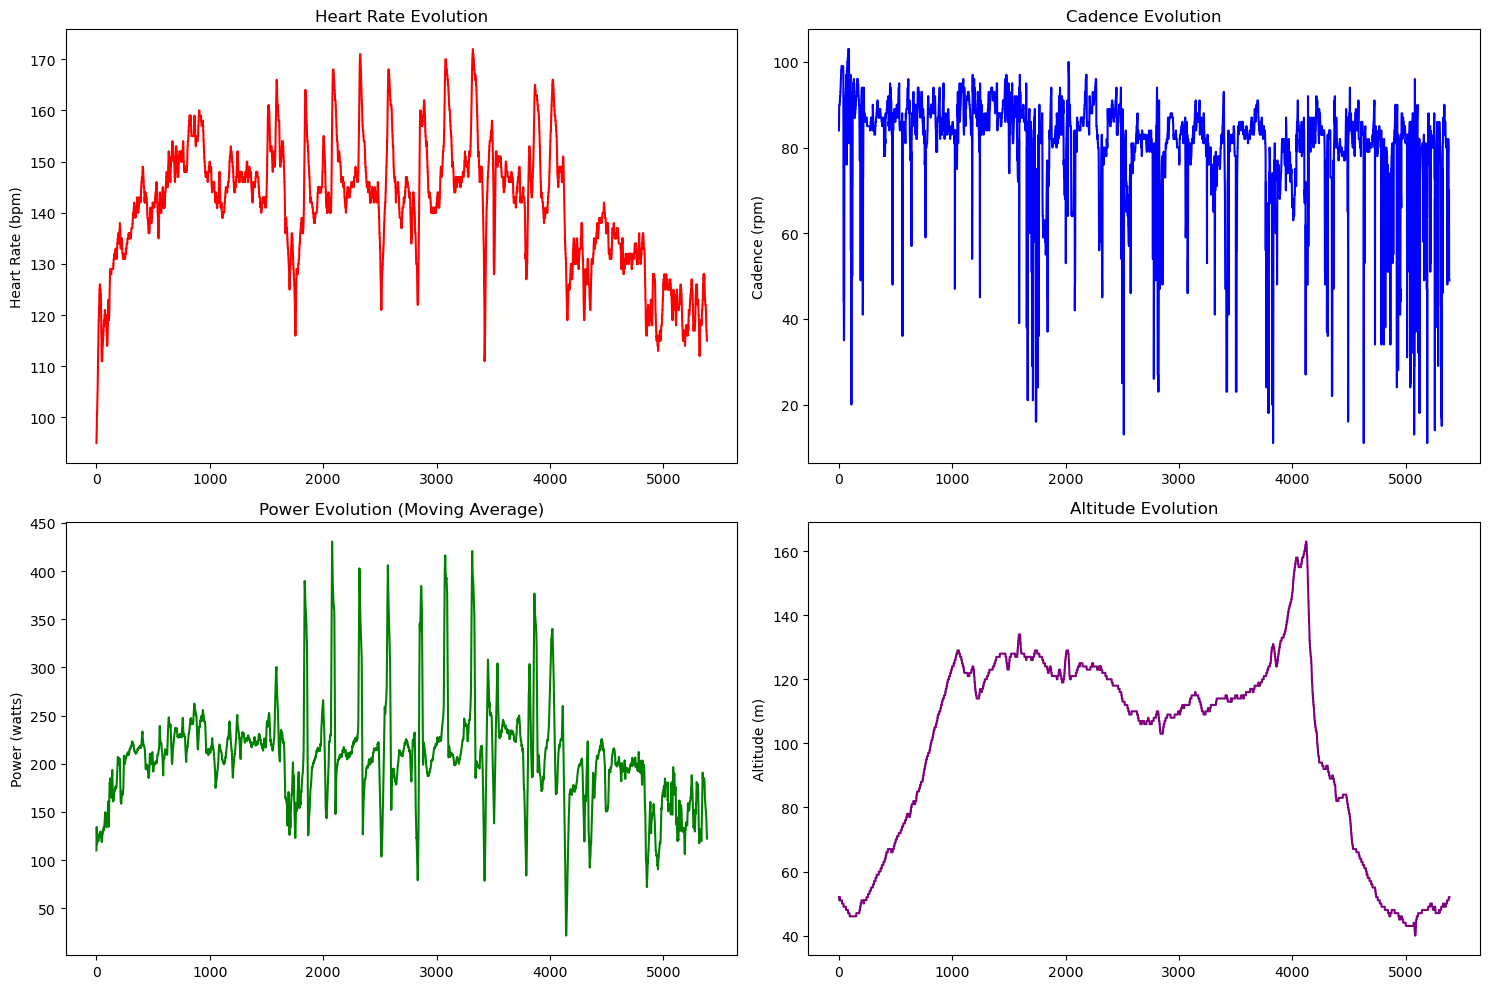

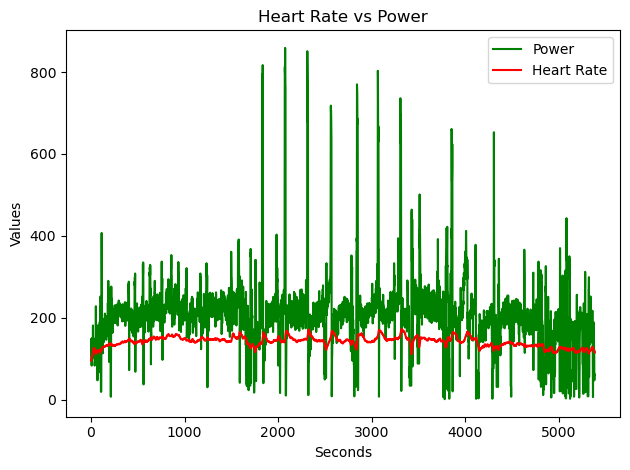

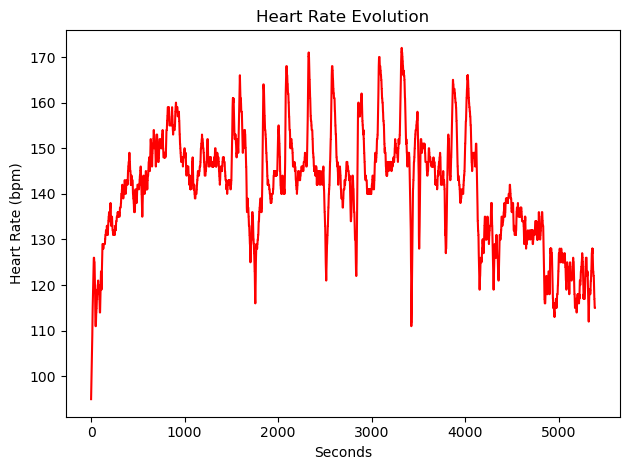

In [17]:
# 1. Select a random file
Path(images).mkdir(exist_ok=True)
selected_file = random.choice(files)
full_path = os.path.join(output_folder, selected_file)

print(f"Analysing file: {selected_file}\n")

# 2. Load the data
df = pd.read_csv(full_path)
print("File successfully loaded\n")

# 3. Basic analysis
print("Basic information:")
print(f"- Number of timesteps: {len(df)}")
print(f"- Number of variables: {len(df.columns)}")
print(f"- Time range: {df['timestamp'].min()} to {df['timestamp'].max()}\n")

print("Descriptive statistics:")
print(df.describe().round(2))

# 4. Visualisations
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.plot(df['heart_rate'], color='red')
plt.title('Heart Rate Evolution')
plt.ylabel('Heart Rate (bpm)')

plt.subplot(2, 2, 2)
plt.plot(df['cadence'], color='blue')
plt.title('Cadence Evolution')
plt.ylabel('Cadence (rpm)')

plt.subplot(2, 2, 3)
plt.plot(df['power_ma'], color='green')
plt.title('Power Evolution (Moving Average)')
plt.ylabel('Power (watts)')

plt.subplot(2, 2, 4)
plt.plot(df['altitude'], color='purple')
plt.title('Altitude Evolution')
plt.ylabel('Altitude (m)')

plt.tight_layout()
plt.show()

# Additional comparison plot
plt.plot(df['timestamp'], df['power'], label='Power', color='green')
plt.plot(df['timestamp'], df['heart_rate'], label='Heart Rate', color='red')
plt.xlabel('Seconds')
plt.ylabel('Values')
plt.title('Heart Rate vs Power')
plt.legend()
plt.tight_layout()
plt.show()

# Save heart rate graph
plt.plot(df['heart_rate'], color='red')
plt.title('Heart Rate Evolution')
plt.ylabel('Heart Rate (bpm)')
plt.xlabel('Seconds')
plt.tight_layout()
plt.savefig("images_exploratory_analysis/heart_rate.pdf", format="pdf", bbox_inches='tight', dpi=300)

### Matriu de correlacions

Com es pot observar les variables més correlades són el temps i la distància juntament amb la freq. cardíaca i la potència.

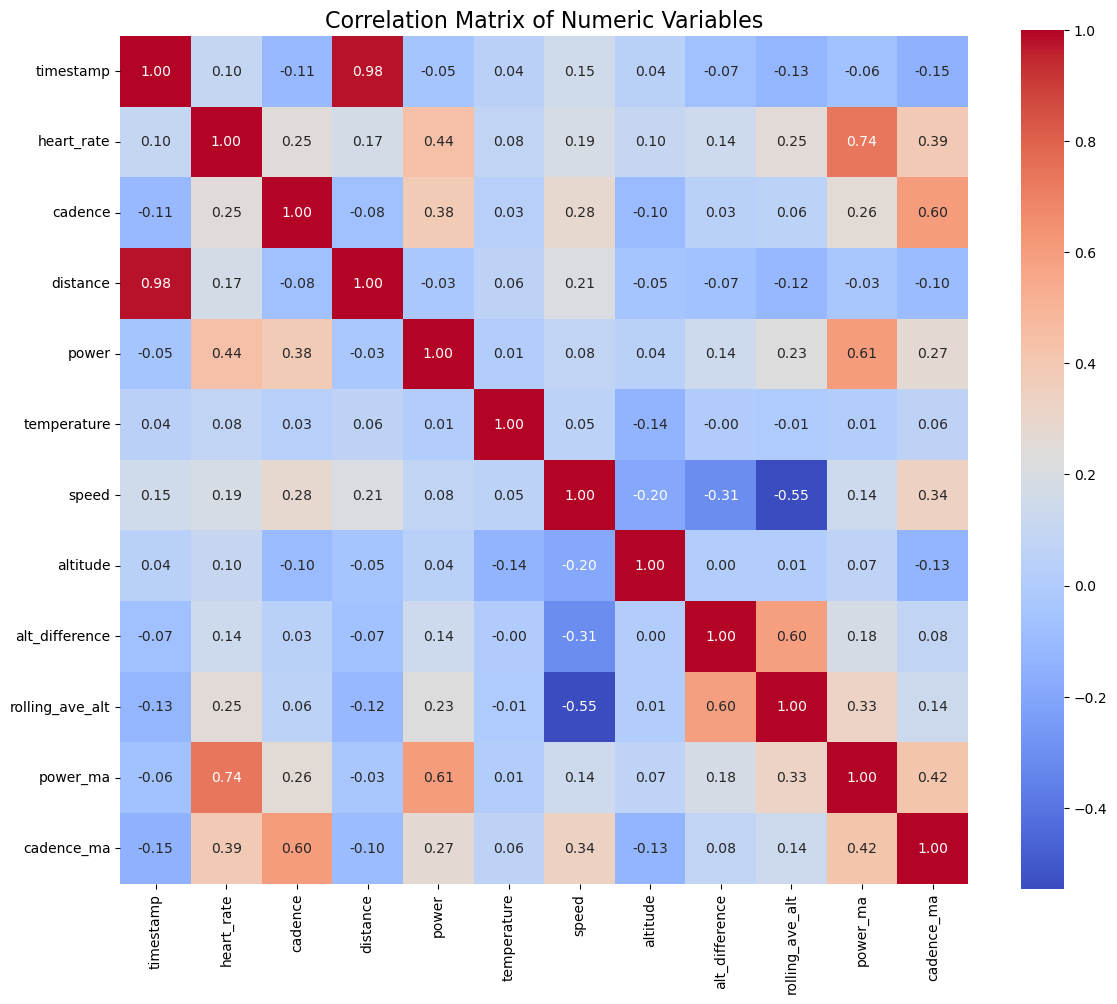

In [19]:
# Load the dataset
df = pd.read_csv("concatenated_data.csv")

# Compute correlation matrix (only numeric columns)
correlation_matrix = df.corr(numeric_only=True)

# Plot correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix of Numeric Variables", fontsize=16)
plt.tight_layout()
plt.savefig("images_exploratory_analysis/correlation.pdf", format="pdf", bbox_inches='tight', dpi=300)
plt.show()

### Descomposició STL

Descomposició STL de la freqüència cardíaca...


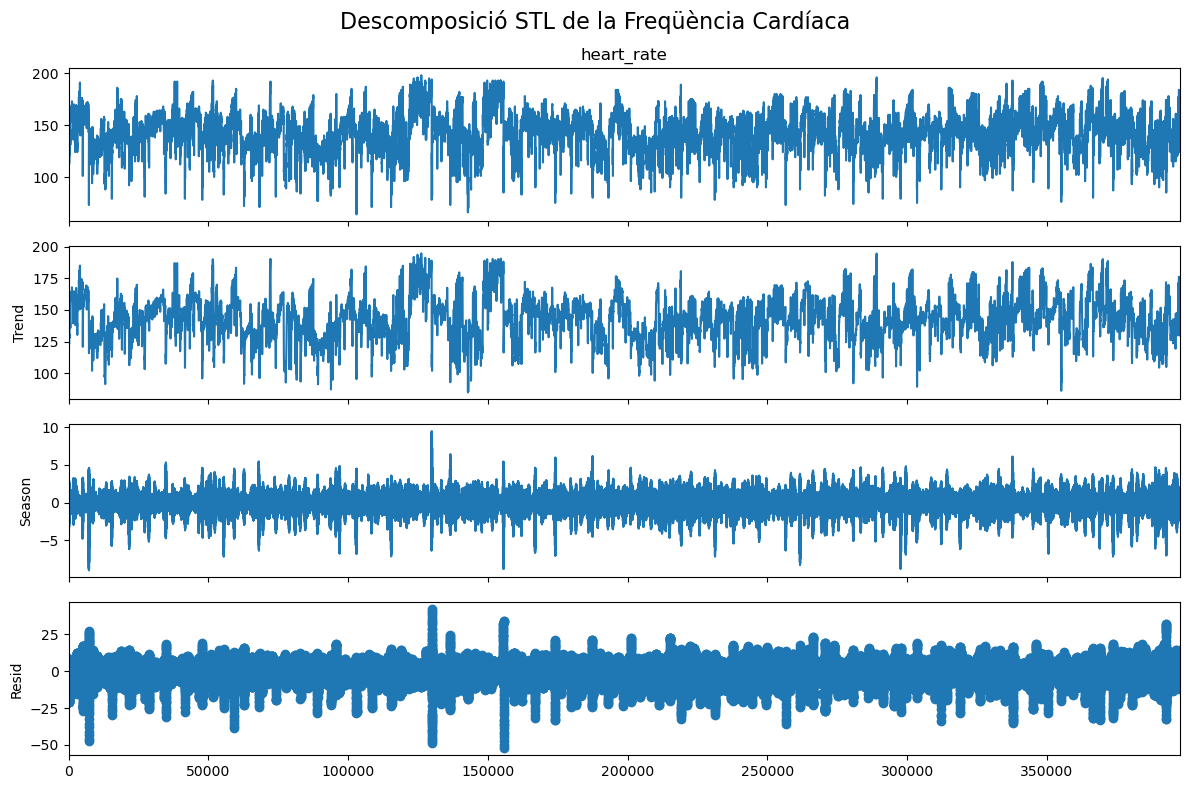

In [41]:
from statsmodels.tsa.seasonal import STL

print("Descomposició STL de la freqüència cardíaca...")
stl = STL(df['heart_rate'], period=60, seasonal=13)  # Period basat en dades de 60s
result = stl.fit()

# Visualització de la descomposició
fig = result.plot()
fig.set_size_inches(12, 8)
plt.suptitle('Descomposició STL de la Freqüència Cardíaca', fontsize=16)
plt.tight_layout()
plt.savefig("images_exploratory_analysis/stl.pdf", format="pdf", bbox_inches='tight', dpi=300)
plt.show()

### Tests d'estacionarietat

In [45]:
from statsmodels.tsa.stattools import adfuller, kpss

print("Test d'Augmented Dickey-Fuller (ADF):")
adf_result = adfuller(df['heart_rate'], autolag='AIC')
print(f"Estadístic ADF: {adf_result[0]:.4f}")
print(f"p-valor: {adf_result[1]:.4f}")
print("Valors crítics:")
for key, value in adf_result[4].items():
    print(f"\t{key}: {value:.4f}")

print("\nTest KPSS:")
kpss_result = kpss(df['heart_rate'], regression='ct', nlags='auto')
print(f"Estadístic KPSS: {kpss_result[0]:.4f}")
print(f"p-valor: {kpss_result[1]:.4f}")
print("Valors crítics:")
for key, value in kpss_result[3].items():
    print(f"\t{key}: {value:.4f}")

# Interpretació dels resultats
print("\nInterpretació:")
if adf_result[1] < 0.05:
    print("- ADF: Sèrie ESTACIONÀRIA (rebutgem H0)")
else:
    print("- ADF: Sèrie NO ESTACIONÀRIA (no rebutgem H0)")

if kpss_result[1] > 0.05:
    print("- KPSS: Sèrie ESTACIONÀRIA (no rebutgem H0)")
else:
    print("- KPSS: Sèrie NO ESTACIONÀRIA (rebutgem H0)")

Test d'Augmented Dickey-Fuller (ADF):
Estadístic ADF: -24.9482
p-valor: 0.0000
Valors crítics:
	1%: -3.4304
	5%: -2.8615
	10%: -2.5668

Test KPSS:
Estadístic KPSS: 0.3604
p-valor: 0.0100
Valors crítics:
	10%: 0.1190
	5%: 0.1460
	2.5%: 0.1760
	1%: 0.2160

Interpretació:
- ADF: Sèrie ESTACIONÀRIA (rebutgem H0)
- KPSS: Sèrie NO ESTACIONÀRIA (rebutgem H0)


C:\Users\alber\AppData\Local\Temp\ipykernel_302140\2517981598.py:12: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(df['heart_rate'], regression='ct', nlags='auto')


### Funcions d'autocorrelació

<Figure size 1500x600 with 0 Axes>

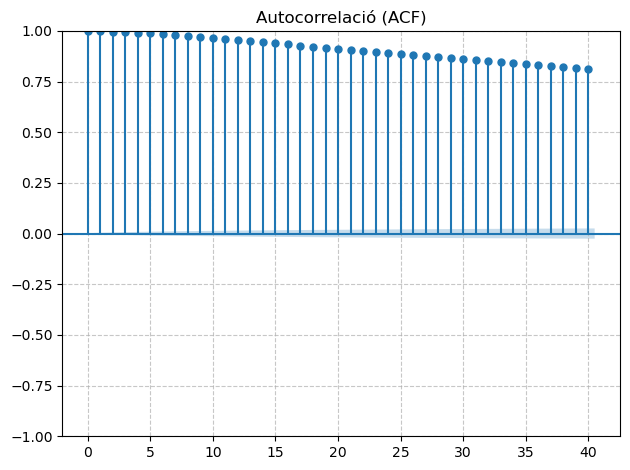

In [48]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(15, 6))

# ACF
plot_acf(df['heart_rate'], lags=40, alpha=0.05, title='Autocorrelació (ACF)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("images_exploratory_analysis/acf.pdf", format="pdf", bbox_inches='tight', dpi=300)
plt.show()

<Figure size 1500x600 with 0 Axes>

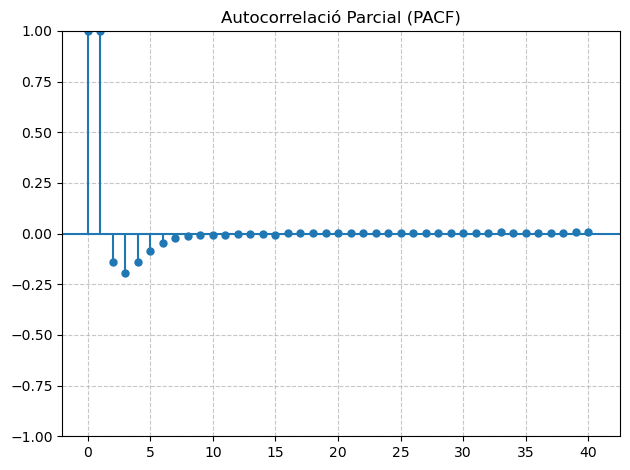

In [49]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(15, 6))

# PACF
plot_pacf(df['heart_rate'], lags=40, alpha=0.05, title='Autocorrelació Parcial (PACF)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("images_exploratory_analysis/pacf.pdf", format="pdf", bbox_inches='tight', dpi=300)
plt.show()